In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
# Очитска данных и EDA (разведочный анализ)

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-customer-segmentation/bank_transactions.csv


In [5]:
df = pd.read_csv('/kaggle/input/bank-customer-segmentation/bank_transactions.csv')

In [6]:
def data_overview(df):
    print(df.head(), "\n")
    print(df.info(), "\n")
    print(df.describe(), "\n")
    print(df.isna().sum(), "\n")

In [7]:
data_overview(df)

  TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1            T2   C2142763      4/4/57          M      JHAJJAR   
2            T3   C4417068    26/11/96          F       MUMBAI   
3            T4   C5342380     14/9/73          F       MUMBAI   
4            T5   C9031234     24/3/88          F  NAVI MUMBAI   

   CustAccountBalance TransactionDate  TransactionTime  \
0            17819.05          2/8/16           143207   
1             2270.69          2/8/16           141858   
2            17874.44          2/8/16           142712   
3           866503.21          2/8/16           142714   
4             6714.43          2/8/16           181156   

   TransactionAmount (INR)  
0                     25.0  
1                  27999.0  
2                    459.0  
3                   2060.0  
4                   1762.5   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 104856

In [8]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

<Figure size 1500x800 with 0 Axes>

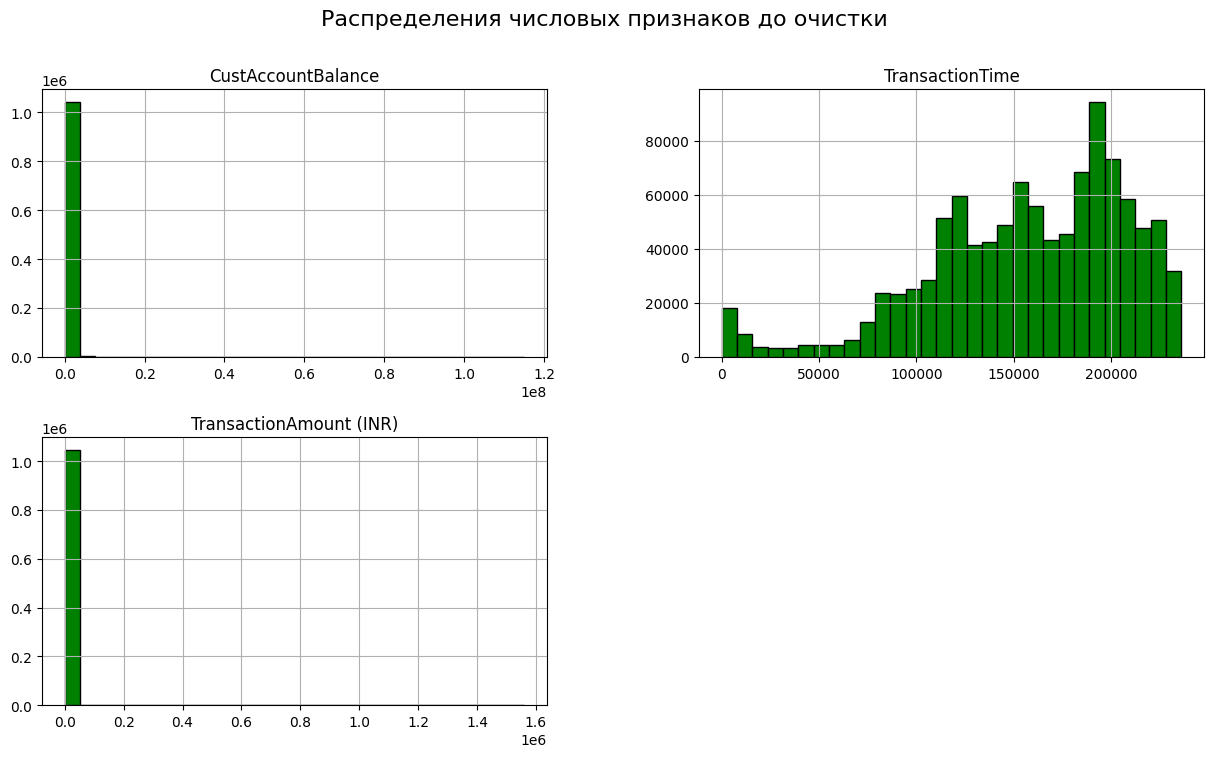

In [9]:
plt.figure(figsize=(15, 8))
df[num_cols].hist(bins=30, figsize=(15, 8), color='g', edgecolor='black')
plt.suptitle("Распределения числовых признаков до очистки", fontsize=16)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[]

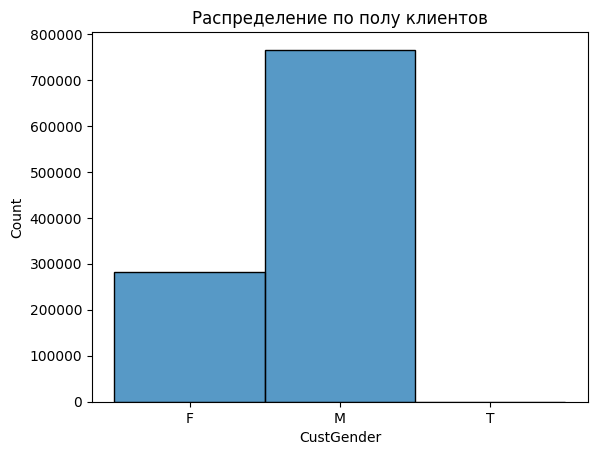

In [10]:
sns.histplot(df["CustGender"])
plt.title("Распределение по полу клиентов")
plt.plot()

In [11]:
df.duplicated().sum() #дубликатов нет

0

In [12]:
df.isna().mean() * 100

TransactionID              0.000000
CustomerID                 0.000000
CustomerDOB                0.323966
CustGender                 0.104905
CustLocation               0.014401
CustAccountBalance         0.225927
TransactionDate            0.000000
TransactionTime            0.000000
TransactionAmount (INR)    0.000000
dtype: float64

In [13]:
# feature engineering

In [14]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')

/tmp/ipykernel_634/3441401514.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
/tmp/ipykernel_634/3441401514.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')


In [15]:
df['CustomerAge'] = (df['TransactionDate'] - df['CustomerDOB']).dt.days // 365

In [16]:
# Заметим, что у нас получился отрицательный возраст. Скорее всего, были допущены ошибки при заполнении данных

In [17]:
df['CustomerAge'].min(), df['CustomerAge'].max()

(-60.0, 217.0)

In [18]:
(df['CustomerAge'] < 0).sum()

105246

In [19]:
df[df['CustomerAge'] < 0]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.00,-42.0
3,T4,C5342380,2073-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.00,-58.0
5,T6,C1536588,2072-08-10,F,ITANAGAR,53609.20,2016-02-08,173940,676.00,-57.0
15,T16,C8334633,2068-10-07,F,NEW DELHI,1283.12,2016-01-08,125725,250.00,-53.0
30,T31,C7648712,2067-01-21,F,NEW DELHI,298461.05,2016-03-08,160642,500.00,-51.0
...,...,...,...,...,...,...,...,...,...,...
1048506,T1048507,C3333984,2070-09-20,M,NAVI MUMBAI,41.82,2016-09-18,182310,878.18,-55.0
1048510,T1048511,C3429427,2048-07-15,M,HOWRAH,416244.74,2016-09-18,184959,1695.00,-32.0
1048536,T1048537,C2939947,2033-05-10,M,NEW DELHI,92173.35,2016-09-18,184556,1319.04,-17.0
1048544,T1048545,C3712582,2071-05-10,M,MUMBAI,25414.52,2016-09-18,182015,400.00,-55.0


In [20]:
# Слишком много ошибочных данных, поэтому не следует удалять. Скорее всего, при заполнении лет ошиблись. Поэтому будет лучше изменить на 100

In [21]:
df.loc[df['CustomerAge'] < 0, 'CustomerAge'] += 100

In [22]:
df.drop(columns=['CustomerDOB'], inplace=True)

In [23]:
data_overview(df)

  TransactionID CustomerID CustGender CustLocation  CustAccountBalance  \
0            T1   C5841053          F   JAMSHEDPUR            17819.05   
1            T2   C2142763          M      JHAJJAR             2270.69   
2            T3   C4417068          F       MUMBAI            17874.44   
3            T4   C5342380          F       MUMBAI           866503.21   
4            T5   C9031234          F  NAVI MUMBAI             6714.43   

  TransactionDate  TransactionTime  TransactionAmount (INR)  CustomerAge  
0      2016-02-08           143207                     25.0         21.0  
1      2016-02-08           141858                  27999.0         58.0  
2      2016-02-08           142712                    459.0         19.0  
3      2016-02-08           142714                   2060.0         42.0  
4      2016-02-08           181156                   1762.5         27.0   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 c

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[]

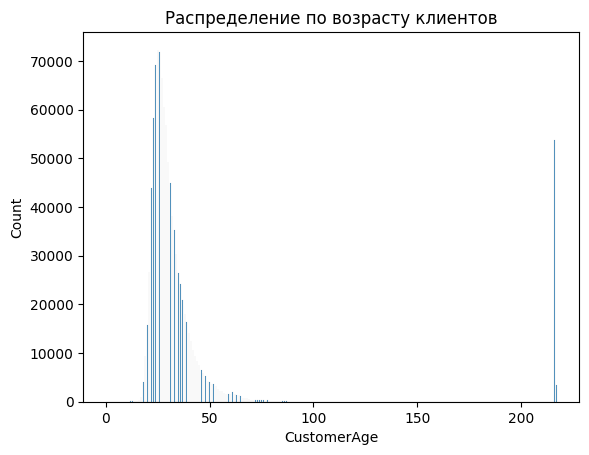

In [24]:
sns.histplot(df["CustomerAge"])
plt.title("Распределение по возрасту клиентов")
plt.plot()

In [25]:
# Обработка выбросов

In [26]:
num_cols = ['CustAccountBalance', 'TransactionTime', 'TransactionAmount (INR)', 'CustomerAge']

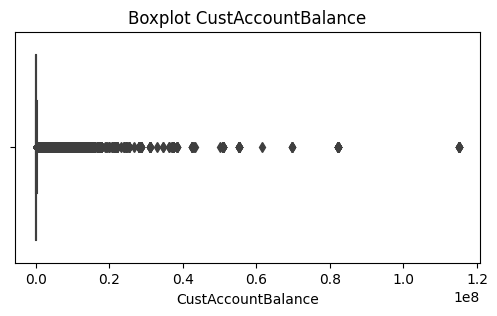

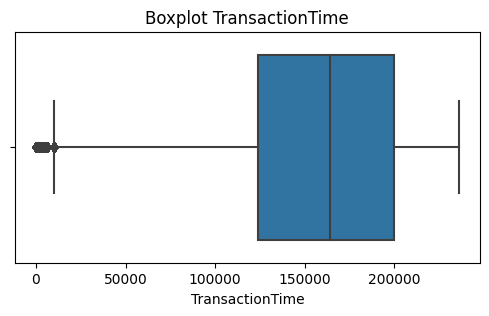

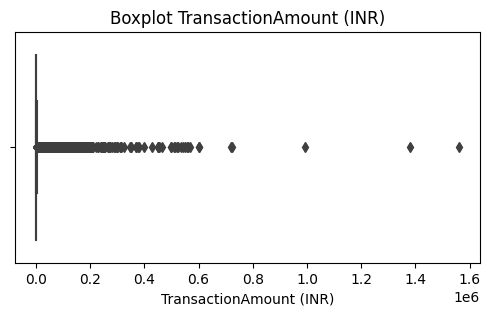

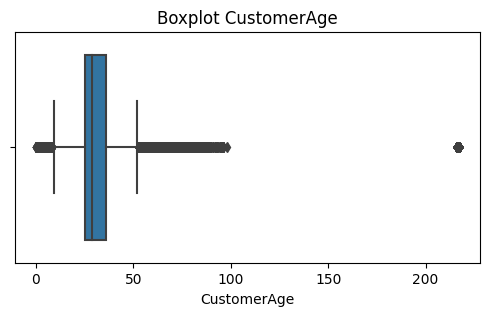

In [27]:
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot {col}")

In [28]:
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        print(f"Размер до обработки {len(df_clean)}")
        df_clean[col] = np.clip(df_clean[col], lower, upper)
        print(f"Размер после обработки {len(df_clean)}")
    return df_clean
        

In [29]:
df = remove_outliers(df, num_cols)

Размер до обработки 1048567
Размер после обработки 1048567
Размер до обработки 1048567
Размер после обработки 1048567
Размер до обработки 1048567
Размер после обработки 1048567
Размер до обработки 1048567
Размер после обработки 1048567


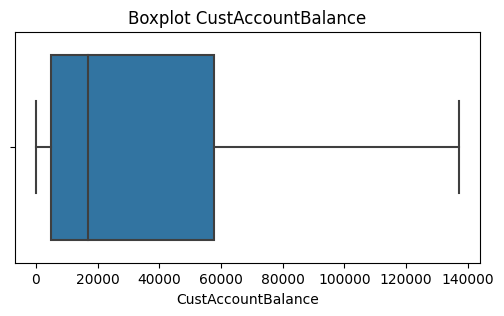

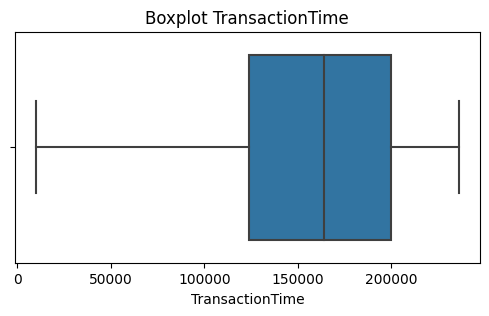

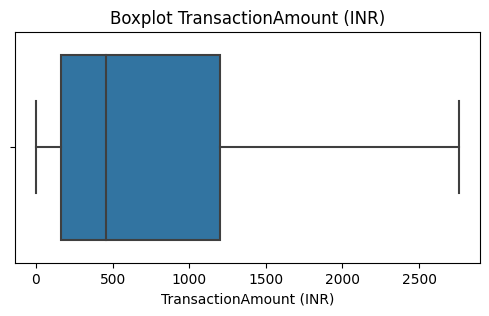

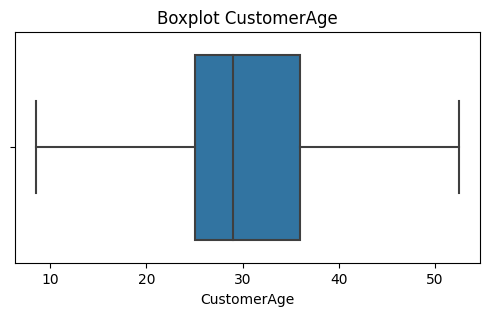

In [30]:
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot {col}")

In [31]:
features_num = ['CustAccountBalance', 'TransactionTime', 'TransactionAmount (INR)', 'CustomerAge']
features_cat = ['CustGender']

In [32]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # заполняем пропуски медианой
    ('scaler', StandardScaler())  # стандартизируем
])

In [33]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # заполняем пропуски модой
    ('onehot', OneHotEncoder(drop='first'))  # кодируем категории
])

In [34]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

In [35]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, features_num),
    ('cat', cat_pipeline, features_cat)
])

In [36]:
data_overview(df)

  TransactionID CustomerID CustGender CustLocation  CustAccountBalance  \
0            T1   C5841053          F   JAMSHEDPUR            17819.05   
1            T2   C2142763          M      JHAJJAR             2270.69   
2            T3   C4417068          F       MUMBAI            17874.44   
3            T4   C5342380          F       MUMBAI           137060.76   
4            T5   C9031234          F  NAVI MUMBAI             6714.43   

  TransactionDate  TransactionTime  TransactionAmount (INR)  CustomerAge  
0      2016-02-08           143207                     25.0         21.0  
1      2016-02-08           141858                   2758.5         52.5  
2      2016-02-08           142712                    459.0         19.0  
3      2016-02-08           142714                   2060.0         42.0  
4      2016-02-08           181156                   1762.5         27.0   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 c

In [37]:
df

,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
0,T1,C5841053,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,21.0
1,T2,C2142763,M,JHAJJAR,2270.69,2016-02-08,141858,2758.5,52.5
2,T3,C4417068,F,MUMBAI,17874.44,2016-02-08,142712,459.0,19.0
3,T4,C5342380,F,MUMBAI,137060.76,2016-02-08,142714,2060.0,42.0
4,T5,C9031234,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,27.0
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,M,NEW DELHI,7635.19,2016-09-18,184824,799.0,26.0
1048563,T1048564,C6459278,M,NASHIK,27311.42,2016-09-18,183734,460.0,24.0
1048564,T1048565,C6412354,M,HYDERABAD,137060.76,2016-09-18,183313,770.0,27.0
1048565,T1048566,C6420483,M,VISAKHAPATNAM,10117.87,2016-09-18,184706,1000.0,38.0


In [38]:
#cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = ['CustGender', 'CustLocation']

In [39]:
num_cols, cat_cols

(['CustAccountBalance',
  'TransactionTime',
  'TransactionAmount (INR)',
  'CustomerAge'],
 ['CustGender', 'CustLocation'])

In [40]:
for col in cat_cols:
    print(df[col].value_counts(), "\n")

CustGender
M    765530
F    281936
T         1
Name: count, dtype: int64 

CustLocation
MUMBAI                         103595
NEW DELHI                       84928
BANGALORE                       81555
GURGAON                         73818
DELHI                           71019
                                ...  
ROAD (E) THANE                      1
TO APOLO PHARMACY BANGALORE         1
PILLAR NO 725 NEW DELHI             1
COMPANY BANGALORE                   1
IMPERIA THANE WEST                  1
Name: count, Length: 9355, dtype: int64 



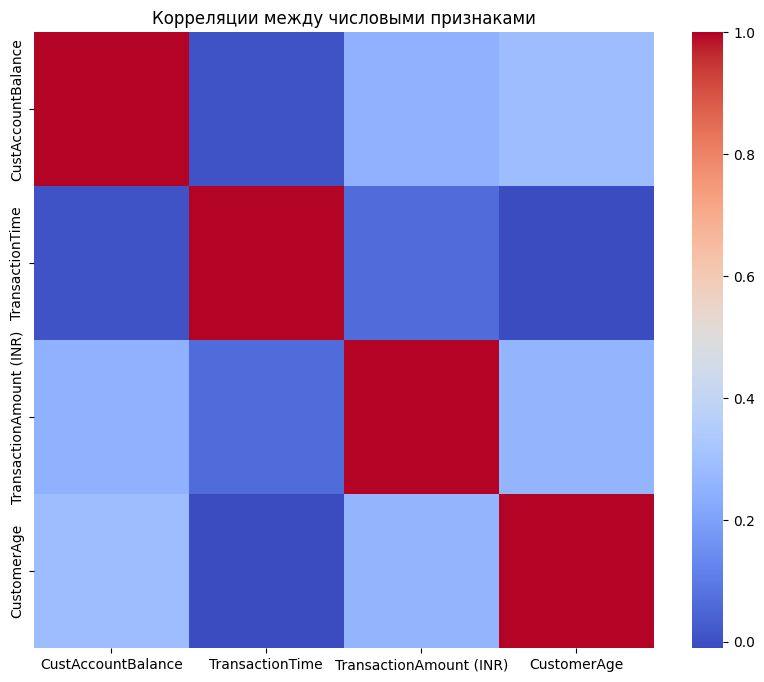

In [41]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', annot=False)
plt.title("Корреляции между числовыми признаками")
plt.show()

In [42]:
# Нет слишком высокой корреляции между переменными. Значит нет необходимости объединять их в новый признак или удалять

In [43]:
# Проанализировать поведение

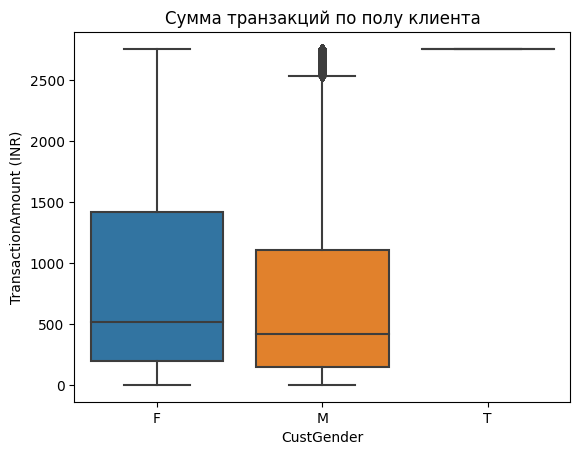

In [44]:
sns.boxplot(data=df, x='CustGender', y='TransactionAmount (INR)')
plt.title("Сумма транзакций по полу клиента")
plt.show()

In [45]:
# Посмотреть на количество транзакций по покупателям

In [46]:
transaction_distribution = df.groupby('CustomerID')['TransactionID'].count().value_counts()
transaction_distribution

TransactionID
1    740653
2    124960
3     16789
4      1702
5       147
6        14
Name: count, dtype: int64

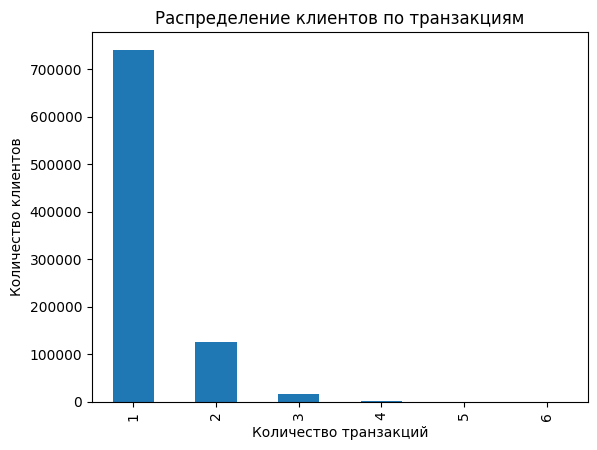

In [47]:
transaction_distribution.plot(kind='bar')
plt.title('Распределение клиентов по транзакциям')
plt.xlabel('Количество транзакций')
plt.ylabel('Количество клиентов')
plt.show()

In [48]:
# Данные показали, что очень часто делается только одна транзакция за 11 месяцев
# Банк теряет деньги из-за низкой лояльности клиентов. Есть смысл запустить программу лояльности

In [49]:
# Анализ денежных потоков

In [50]:
# Сегментация клиентов

In [51]:
money_stats = df.groupby('CustomerID')['TransactionAmount (INR)'].agg(['sum', 'mean', 'count'])
money_stats.rename(columns={'sum':'TotalSpent', 'mean':'AvgTransaction', 'count':'NumTransactions'}, inplace=True)
money_stats.head()

,TotalSpent,AvgTransaction,NumTransactions
CustomerID,,,
C1010011,3114.5,1557.25,2
C1010012,1499.0,1499.00,1
C1010014,1455.0,727.50,2
C1010018,30.0,30.00,1
C1010024,2758.5,2758.50,1


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


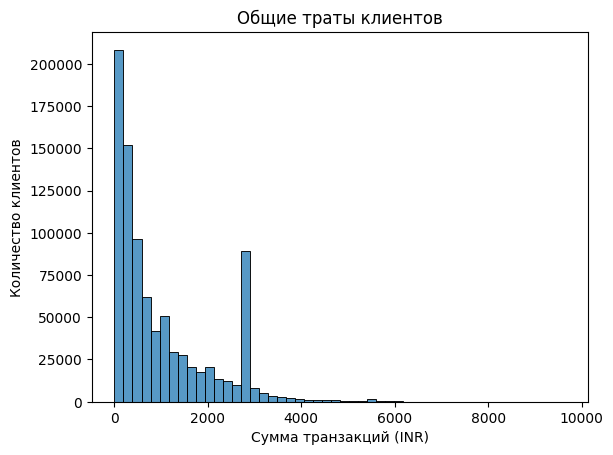

In [52]:
sns.histplot(money_stats['TotalSpent'], bins=50)
plt.title('Общие траты клиентов')
plt.xlabel('Сумма транзакций (INR)')
plt.ylabel('Количество клиентов')
plt.show()

Простая и наглядная ручная сегментация, однако учитывается только один признак

In [53]:
low = money_stats['TotalSpent'].quantile(0.25)
high = money_stats['TotalSpent'].quantile(0.75)

In [54]:
print(low, high)

200.0 1500.0


In [55]:
money_stats['Segment'] = pd.cut(
    money_stats['TotalSpent'],
    bins=[-np.inf, low, high, np.inf],
    labels=['Low', 'Medium', 'High']
)
money_stats['Segment'].value_counts()

Segment
Medium    426716
Low       236932
High      220617
Name: count, dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


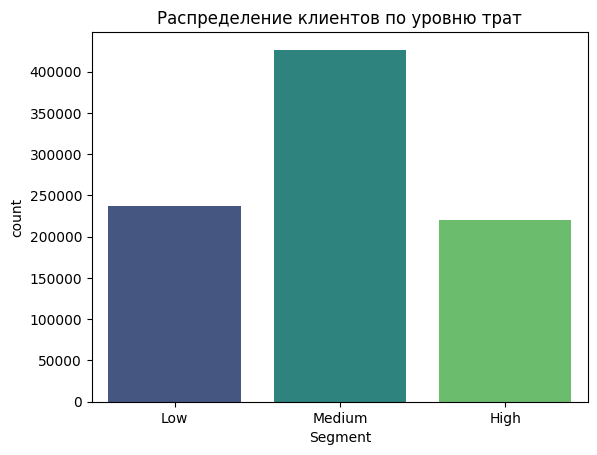

In [56]:
sns.countplot(x='Segment', data=money_stats, palette='viridis')
plt.title('Распределение клиентов по уровню трат')
plt.show()

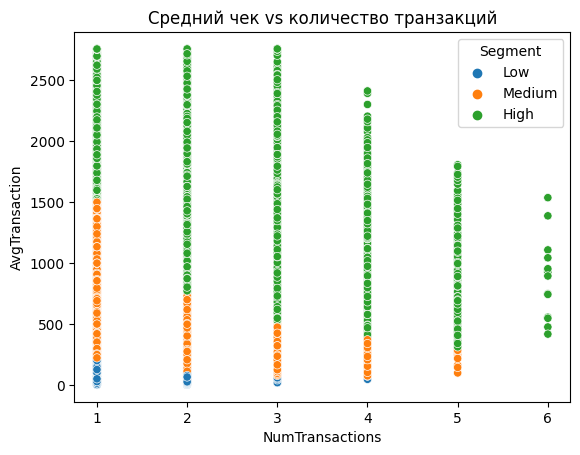

In [57]:
sns.scatterplot(x='NumTransactions', y='AvgTransaction', hue='Segment', data=money_stats)
plt.title('Средний чек vs количество транзакций')
plt.show()

Точки с малым NumTransactions и высоким AvgTransaction — это редкие, но дорогие покупки. Это потенциально ценные клиенты для VIP-программ.
Точки с высоким NumTransactions и низким AvgTransaction — активные клиенты с низким средним чеком. Их можно стимулировать через акции или кросс-продажи.

In [58]:
# Кластеризация

In [60]:
X_prepared = preprocessor.fit_transform(df)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

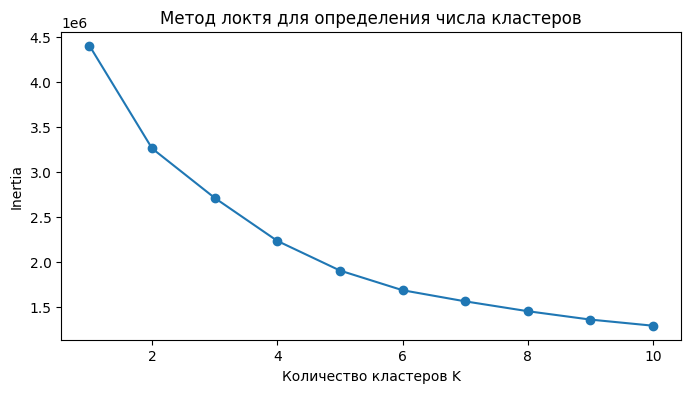

In [61]:
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_prepared)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, marker='o')
plt.title('Метод локтя для определения числа кластеров')
plt.xlabel('Количество кластеров K')
plt.ylabel('Inertia')
plt.show()

In [75]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_prepared)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [77]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_prepared)
df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


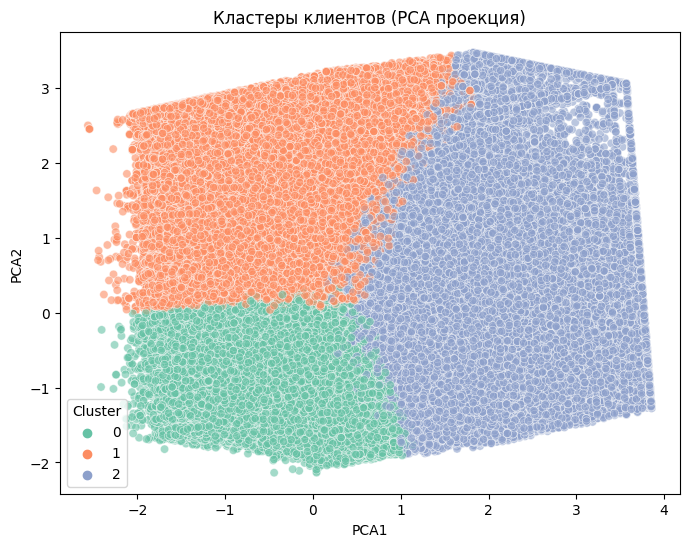

In [78]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='Set2', alpha=0.6)
plt.title('Кластеры клиентов (PCA проекция)')
plt.show()

In [82]:
df.groupby('Cluster')[features_num].mean()

,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustomerAge
Cluster,,,,
0,17693.939542,191466.464296,613.425755,28.290437
1,20785.250247,100223.207982,441.287862,28.961834
2,93340.392116,161925.532714,1577.618278,39.467109


In [83]:
df['Cluster'].value_counts()

Cluster
0    458524
1    299589
2    290454
Name: count, dtype: int64

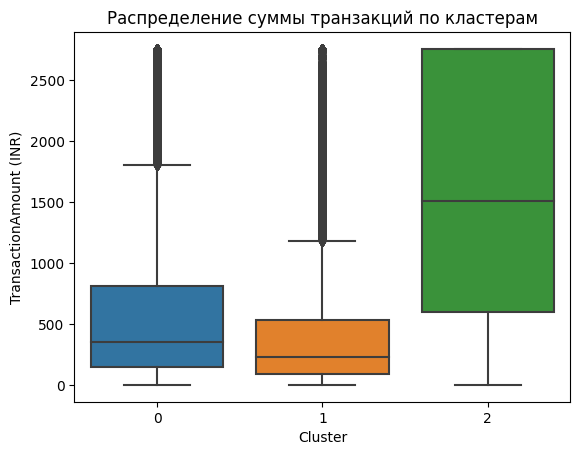

In [84]:
sns.boxplot(data=df, x='Cluster', y='TransactionAmount (INR)')
plt.title("Распределение суммы транзакций по кластерам")
plt.show()

In [85]:
pd.crosstab(df['Cluster'], df['CustGender'], normalize='index') * 100

CustGender,F,M,T
Cluster,,,
0,27.986014,72.013986,0.000000
1,23.788695,76.211305,0.000000
2,28.452470,71.547185,0.000345


In [88]:
top_locations = df['CustLocation'].value_counts().nlargest(20).index
df['LocationGrouped'] = df['CustLocation'].where(df['CustLocation'].isin(top_locations), 'Other')

In [89]:
location_dist = pd.crosstab(df['Cluster'], df['LocationGrouped'], normalize='index') * 100
print(location_dist)

LocationGrouped  AHMEDABAD  BANGALORE  CHANDIGARH   CHENNAI     DELHI  \
Cluster                                                                 
0                 1.126440   8.303600    0.855353  2.876622  6.683402   
1                 1.186292   7.632790    0.894225  2.652300  6.918812   
2                 1.220503   7.097165    1.007044  3.054873  6.763894   

LocationGrouped  FARIDABAD  GHAZIABAD   GURGAON  HYDERABAD    JAIPUR  ...  \
Cluster                                                               ...   
0                 1.070391   1.369612  6.734871   2.319399  1.006708  ...   
1                 1.157920   1.406927  6.464857   2.278789  0.974001  ...   
2                 1.012553   1.838157  8.114538   1.923540  0.821817  ...   

LocationGrouped   LUCKNOW    MOHALI     MUMBAI  NAVI MUMBAI  NEW DELHI  \
Cluster                                                                  
0                0.780548  0.598660   9.237248     1.232869   6.868561   
1                0.732337 

Массовые и малодоходные клиенты распределены по всей стране. VIP клиенты сосредоточены в крупных мегаполисах (MUMBAI, NEW DELHI, GURGAON)

Кластер 0

Баланс: низкий (~17.7 тыс.)

Сумма транзакций: средняя (~613 INR)

Возраст: молодой (~28 лет)

Количество клиентов: самый крупный кластер (458 тыс.)

Пол: преобладание мужчин (~72%)

Инсайты:

Это молодые клиенты с низким балансом, совершают средние по размеру транзакции.

Большая часть клиентов, то есть это массовый сегмент, который важно удерживать.

Возможны акции по повышению лояльности, стимулирование повторных покупок.

Кластер 1

Баланс: немного выше (~20.7 тыс.)

Сумма транзакций: низкая (~441 INR)

Возраст: молодой (~29 лет)

Количество клиентов: среднее (300 тыс.)

Пол: преобладание мужчин (~76%)

Инсайты:

Молодые клиенты с низким балансом и низкой активностью.

Эти клиенты делают редкие и небольшие по сумме покупки.

Для банка это слабововлечённый сегмент, стоит стимулировать через акции, кэшбэк, персональные предложения.

Кластер 2

Баланс: очень высокий (~93 тыс.)

Сумма транзакций: высокая (~1 578 INR)

Возраст: зрелый (~39 лет)

Количество клиентов: меньше всего (290 тыс.)

Пол: сбалансирован, мужчины 71%, женщины 28%

Инсайты:

Это крупные клиенты с высокими балансами, делают крупные транзакции.

Очень ценный сегмент для банка — VIP клиенты.

Рекомендуется персональное обслуживание, премиальные продукты, инвестиционные предложения.

Разные кластеры требуют разных стратегий продвижения:

Кластер 2 → VIP-кампании, дорогие персонализированные предложения.

Кластер 0 → массовые рассылки, стандартные акции.

Кластер 1 → бюджетные стимулы, кэшбэк.

Эффект: маркетинг становится таргетированным, тратим меньше на неэффективные кампании.